In [166]:
# Alle notwendigen Import werden Hier gemacht

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json
from pathlib import Path
import json

In [167]:
import math

def cholesky_factorization(a):
    n = len(a)
    l = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1):
            sum_val = sum(l[i][k] * l[j][k] for k in range(j))
            if i == j:
                l[i][j] = math.sqrt(a[i][i] - sum_val)
            else:
                l[i][j] = (a[i][j] - sum_val) / l[j][j]
    return l

def forward_substitution(l, b):
    n = len(b)
    y = [0.0 for _ in range(n)]
    y[0] = b[0] / l[0][0]
    for i in range(1, n):
        sume = sum(l[i][j] * y[j] for j in range(i))
        y[i] = (b[i] - sume) / l[i][i]
    return y

def backward_substitution(lt, y):
    n = len(y)
    x = [0.0 for _ in range(n)]
    x[n - 1] = y[n - 1] / lt[n - 1][n - 1]

    for i in range(n - 2, -1, -1):
        sume = sum(lt[i][j] * x[j] for j in range(i + 1, n))
        x[i] = (y[i] - sume) / lt[i][i]
       
    return x

def solve_linear_equation_system(a, b):
    n = len(b)
    l = cholesky_factorization(a)
    # Transposer L pour avoir L^T
    lt = [[l[j][i] for j in range(n)] for i in range(n)]
    y = forward_substitution(l, b)
    x = backward_substitution(lt, y)
    return x


In [168]:
# Methode zum Einlesen der Daten und Berechnen der Laufszeiten.

def read_and_compute_runtime(filename):
    df = pd.read_csv(filename, sep=r"\s+", header=None,
                     names=["id", "start", "pre_end", "solver_end"])

    time_format = "%d.%m.%Y-%H:%M:%S"
    df["start"] = pd.to_datetime(df["start"], format=time_format)
    df["solver_end"] = pd.to_datetime(df["solver_end"], format=time_format)
    df["runtime_s"] = (df["solver_end"] - df["start"]).dt.total_seconds()

    return df

# r1=read_and_compute_runtime("runtimes.mp80")
#print(r1)


In [169]:
#Methode read_and_compute_runtime aufrufen, Laufzeiten, Mittelwerte, Varianz , median und standardabweichungen  von Jede Prozessor berechnen
# und in einem DataFrame (~ Dictionary ) speichern 

files = {
    "Intel N95 (mp80)": "runtimes.mp80",
    "Intel N100": "runtimes.n100",
    "Raspberry Pi 5": "runtimes.pi5"
}

data = {name: read_and_compute_runtime(path) for name, path in files.items()}
#print(data)

results=[]
for name, df in data.items():
    mean = df["runtime_s"].mean()
    median = df["runtime_s"].median()
    var = df["runtime_s"].var()
    std = df["runtime_s"].std()
    max=df["runtime_s"].max()
    min=df["runtime_s"].min()
    
    
    results.append({'Name': name,'Mean': mean,'Median': median,'Standardabweichung': std, 'MinZeit (in Sekunden)': min,'MaxZeit(in Sekunden': max})

# jetz als DataFrame umwandeln
mmvs_df = pd.DataFrame(results)

#print(mmvs_df)

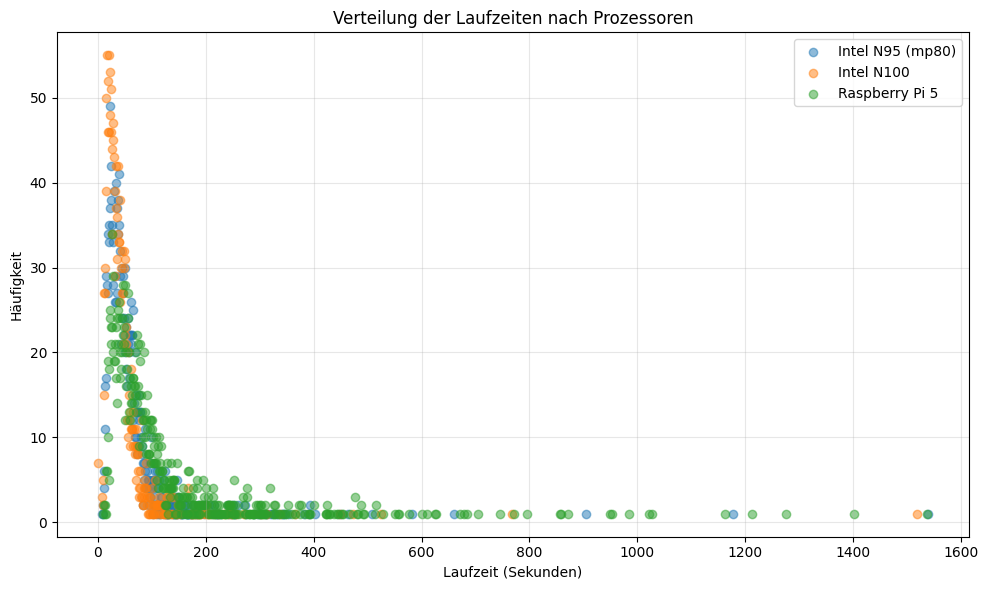

In [170]:
plt.ion()
plt.figure(figsize=(10, 6))

counts_dict = {}
for name, df in data.items():
    
    runtimes_rounded = df["runtime_s"] #.round(1)
    counts = runtimes_rounded.value_counts().sort_index()
    counts_dict[name]=counts
    counts = counts[(counts.index >= 0) & (counts.index <= 2000)]
    counts=counts[(counts.values>=0 )& (counts.values<=250)]
    plt.scatter(counts.index,counts.values , label=name,alpha=0.5)
    #plt.plot(counts.index, counts.values, label=name)
    
plt.xlabel("Laufzeit (Sekunden)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Laufzeiten nach Prozessoren")
#plt.xlim(-10, 600)
#plt.ylim(-10, 80)
plt.legend()
plt.legend()
plt.tight_layout()
plt.savefig("runtime_distribution111.png") 
plt.grid(True, alpha=0.3)
plt.show()

counts_df=pd.DataFrame(counts_dict); counts_df = counts_df.fillna(0) # Laufzeiten und deren Haufigken in einem DataFrame gespeichert.
#print(counts_df)

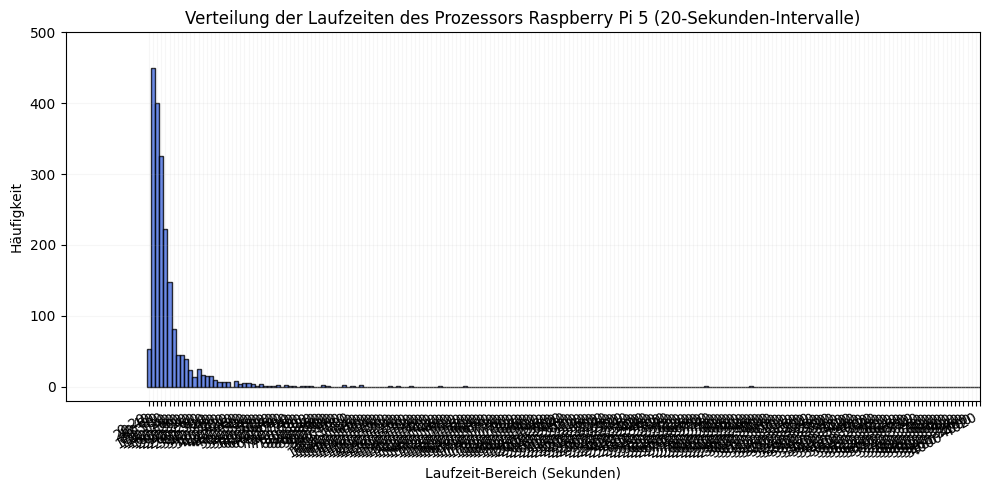

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_Pi5 = data["Raspberry Pi 5"]
runtimes = df_Pi5["runtime_s"]

# 20-Sekunden-Intervalle
bins = np.arange(0, runtimes.max() + 20, 20)

# In Intervalle einteilen
categories = pd.cut(runtimes, bins=bins, right=True)

# Häufigkeit zählen
counts = categories.value_counts().sort_index()

# Labels schöner machen ([a, b])
labels = [f"{int(c.left)}-{int(c.right)}" for c in counts.index]

plt.figure(figsize=(10,5))
plt.bar(labels, counts.values, color="royalblue", edgecolor="black", width=1.0, alpha=0.8)

plt.xlabel("Laufzeit-Bereich (Sekunden)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Laufzeiten des Prozessors Raspberry Pi 5 (20-Sekunden-Intervalle)")
plt.xticks(rotation=30, ha="right")

# Fokus auf Hauptbereich
plt.ylim(-20, 500)
plt.xlim(-20, 200)  # Zoom auf 0–200 Sekunden
plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()


In [172]:
import json
import tarfile
from pathlib import Path

def load_dimensions(archive_path):
    """
    Lit toutes les instances JSON d'une archive .tar.gz
    et retourne une liste des dimensions trouvées.
    """
    dimensions = []

    with tarfile.open(archive_path, "r:gz") as tar:
        members = []
        for m in tar.getmembers():
            name = Path(m.name).stem
            parts = name.split('_')
            last = parts[-1]
            # On ne garde que les fichiers se terminant par un nombre (ex: _0.json)
            if last.isdigit():
                members.append(m)

        # Trier les fichiers dans l'ordre numérique (_0, _1, ..., _1999)
        members = sorted(members, key=lambda x: int(x.name.split('_')[-1].split('.')[0]))

        # Extraire la dimension de chaque fichier JSON
        for member in members:
            f = tar.extractfile(member)
            if f:
                js = json.load(f)
                if "dimension" in js:
                    dimensions.append(js["dimension"])

    # print(f"{len(dimensions)} dimensions lues depuis {archive_path}")
    return dimensions


In [173]:
import pandas as pd

def combine_dimensions_runtimes(dimensions, runtimes, label=None): 
    n = 2000
    # Créer un DataFrame
    df = pd.DataFrame({
        'dimension': dimensions[:n],
        'runtime': runtimes[:n],
        'dataset': label
    })

    # print(f"✅ DataFrame créé avec {len(df)} lignes pour {label}")
    return df


In [174]:
# 1. Charger les données
dims_300_700 = load_dimensions(r"C:\GitProjekts\PDA\b300_700.1.tar.gz")

dims_700_1000 = load_dimensions(r"C:\GitProjekts\PDA\b700_1000.1.tar.gz")

In [175]:
runs_300_700 = read_and_compute_runtime(r"C:\GitProjekts\PDA\b300_700.1\runtimes.mp80")
runs_700_1000 =read_and_compute_runtime(r"C:\GitProjekts\PDA\b700_1000.1\runtimes.mp80")
print(runs_300_700["runtime_s"])

# 2. Combiner chaque dataset
df_300_700 = combine_dimensions_runtimes(dims_300_700, runs_300_700["runtime_s"], "b300_700.1")
df_700_1000 = combine_dimensions_runtimes(dims_700_1000, runs_700_1000["runtime_s"], "b700_1000.1")

# 3. Fusionner les deux en un seul grand DataFrame
df_all = pd.concat([df_300_700, df_700_1000], ignore_index=True)

print(df_all)

0        54.0
1        16.0
2       924.0
3        53.0
4        19.0
        ...  
1995     45.0
1996     99.0
1997     11.0
1998    153.0
1999     42.0
Name: runtime_s, Length: 2000, dtype: float64
      dimension  runtime      dataset
0           521     54.0   b300_700.1
1           339     16.0   b300_700.1
2           667    924.0   b300_700.1
3           554     53.0   b300_700.1
4           380     19.0   b300_700.1
...         ...      ...          ...
3995        761    286.0  b700_1000.1
3996        751    387.0  b700_1000.1
3997        708    303.0  b700_1000.1
3998        745    101.0  b700_1000.1
3999        704    331.0  b700_1000.1

[4000 rows x 3 columns]


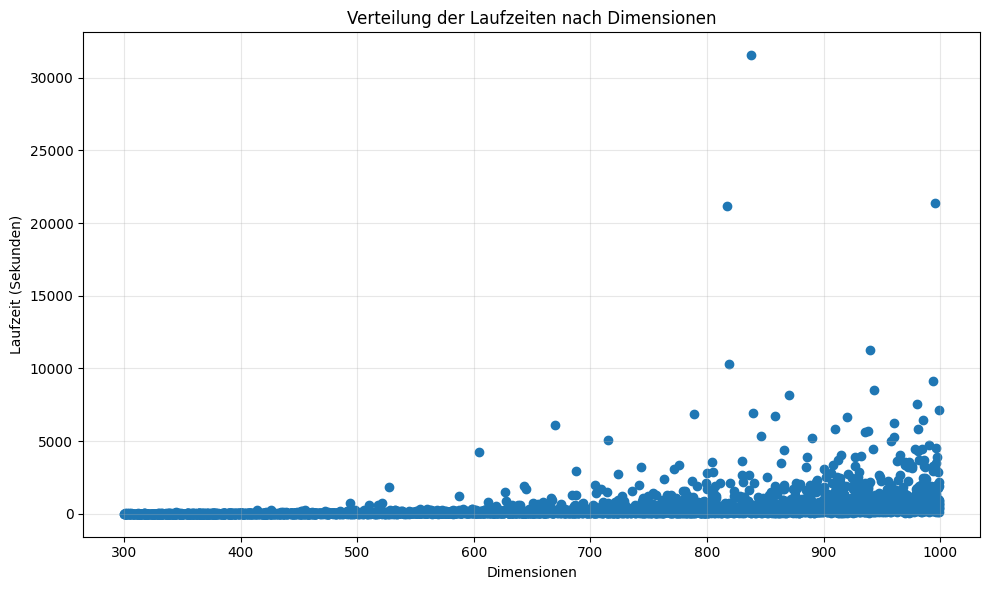

In [176]:
plt.ion()
plt.figure(figsize=(10, 6))

plt.scatter(df_all["dimension"],df_all["runtime"] ,)
#plt.plot(counts.index, counts.values, label=name)
plt.xlabel("Dimensionen")
plt.ylabel("Laufzeit (Sekunden)")
plt.title("Verteilung der Laufzeiten nach Dimensionen")
#plt.xlim(-10, 600)
#plt.ylim(-10, 80)
plt.tight_layout()
plt.savefig("runtime_distribution111.png") 
plt.grid(True, alpha=0.3)
plt.show()

In [177]:
bins= np.arange(300, 1000, 20)
labels = [f"{b}-{b+19}" for b in bins]

df_all["dim_group"] = pd.cut( df_all["dimension"],bins=np.append(bins, 1000),labels=labels,include_lowest=True)

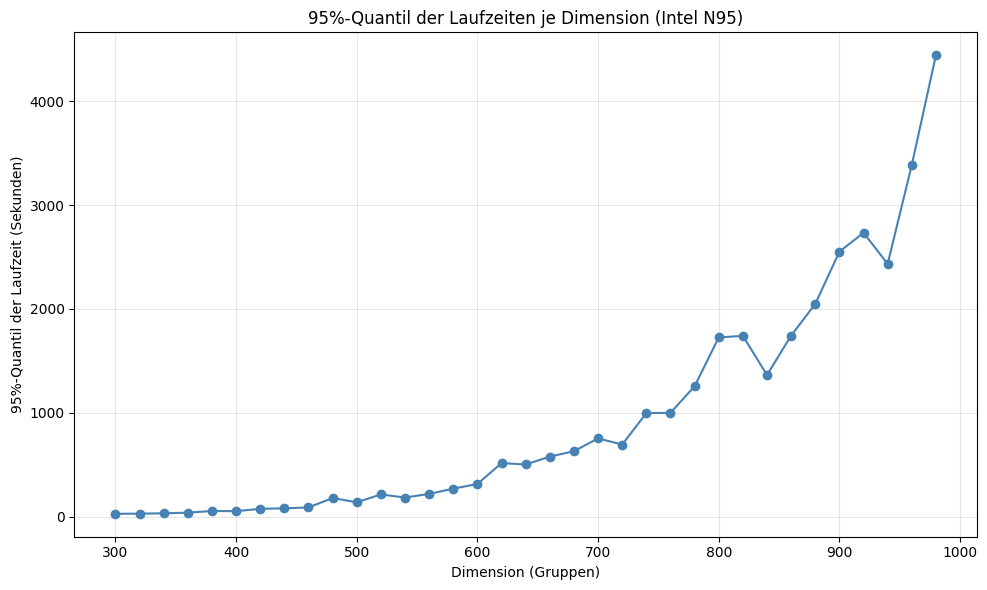

In [178]:
quantiles = df_all.groupby("dim_group", observed=True)["runtime"].quantile(0.95).dropna()

# Plot 95% quantile vs dimension
plt.figure(figsize=(10, 6))
plt.plot(bins[:len(quantiles)], quantiles.values, marker="o", linestyle="-", color="steelblue")

plt.xlabel("Dimension (Gruppen)")
plt.ylabel("95%-Quantil der Laufzeit (Sekunden)")
plt.title("95%-Quantil der Laufzeiten je Dimension (Intel N95)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("quantile_95_plot.2.png")
plt.show()

In [187]:
anzahl_Bereiche=len(quantiles.index)
X=[((300+i*20 -20)+(300+i*20 -1))/2 for i in range(1,anzahl_Bereiche+1)]
A=[X,[1 for _ in range(anzahl_Bereiche)]]
y=np.array([a for a in np.log(quantiles.values)])
A=np.array(A).T
print(A)
print(A.shape)
A_T=A.T 
Anew=A_T@A
ynew=A_T@y
print(Anew)
print(ynew)

[[309.5   1. ]
 [329.5   1. ]
 [349.5   1. ]
 [369.5   1. ]
 [389.5   1. ]
 [409.5   1. ]
 [429.5   1. ]
 [449.5   1. ]
 [469.5   1. ]
 [489.5   1. ]
 [509.5   1. ]
 [529.5   1. ]
 [549.5   1. ]
 [569.5   1. ]
 [589.5   1. ]
 [609.5   1. ]
 [629.5   1. ]
 [649.5   1. ]
 [669.5   1. ]
 [689.5   1. ]
 [709.5   1. ]
 [729.5   1. ]
 [749.5   1. ]
 [769.5   1. ]
 [789.5   1. ]
 [809.5   1. ]
 [829.5   1. ]
 [849.5   1. ]
 [869.5   1. ]
 [889.5   1. ]
 [909.5   1. ]
 [929.5   1. ]
 [949.5   1. ]
 [969.5   1. ]
 [989.5   1. ]]
(35, 2)
[[1.61927588e+07 2.27325000e+04]
 [2.27325000e+04 3.50000000e+01]]
[146418.5406086     209.07035047]


In [192]:
result=solve_linear_equation_system(Anew,ynew)
lamda1= np.exp(result[1])
print(lamda1)
lamda2=result[0]
f_x_=[lamda1*np.exp(lamda2*x) for x in X]

print(result)
print(0.007442120430924863*389.5 +1.1397813651023168)

3.126084819230777
[0.007442120430924863, 1.1397813651023168]
4.038487272947551


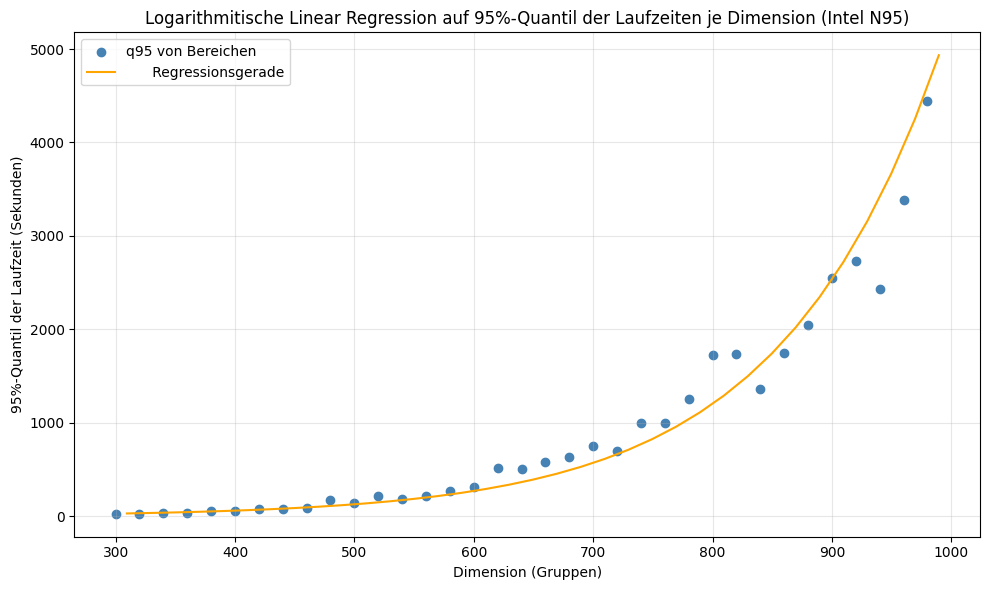

In [ ]:
# Plot 95% quantile vs dimension
plt.figure(figsize=(10, 6))
plt.scatter(bins[:len(quantiles)], quantiles.values, color="steelblue", label="q95 von Bereichen")
plt.plot(X,f_x_,linestyle="-", color="orange", label="Regressionsgerade")

plt.xlabel("Dimension (Gruppen)")
plt.ylabel("95%-Quantil der Laufzeit (Sekunden)")
plt.title("Logarithmitische Linear Regression auf 95%-Quantil der Laufzeiten je Dimension (Intel N95)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("LogLinearRegress.png")
plt.show()

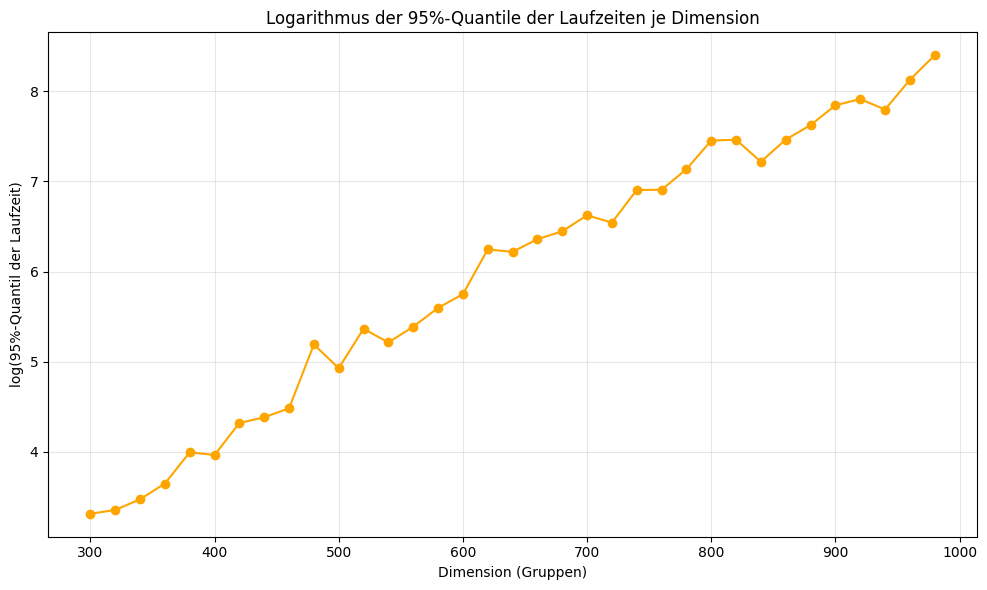

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bins[:len(quantiles)], np.log(quantiles.values), marker="o", linestyle="-", color="orange")
plt.xlabel("Dimension (Gruppen)")
plt.ylabel("log(95%-Quantil der Laufzeit)")
plt.title("Logarithmus der 95%-Quantile der Laufzeiten je Dimension")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("quantile_log_plot.2.png")
plt.show()